In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import sys
import json
import copy
import pickle
from hashlib import sha256
import random

In [3]:
import pandas as pd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
from tqdm.notebook import tqdm

In [4]:
sys.path.append('../lared')
from helpers import file_functions
from dataset.example import VideoExample, AudioExample, FullExample
from constants.laughter_constants import data_path, cloud_data_path
from data_loading.utils import get_video_caps, AudioFiles

In [5]:
VideoExample.init_caps(get_video_caps('/media/jose/HDD/data/lared/concat'))
VideoExample.init_camera_annotation(os.path.join(cloud_data_path, 'camera.txt'))
AudioExample.init_dataset(AudioFiles('/media/jose/HDD/data/lared/audio/trimmed'))

In [6]:
# load ELAN annotations
laughter_ann_path = os.path.join(cloud_data_path, 'laughter.txt')
# path for output images
out_path = os.path.join(cloud_data_path, 'pilot')
images_path = os.path.join(out_path, 'images')


laughter_ann = pd.read_csv(laughter_ann_path, sep='\t',names=['name','participant','ini','fin','dur','type'],header=None)
df_laughter_by_participant = laughter_ann.groupby('participant')

In [7]:
dfs_laughter = []
for i in df_laughter_by_participant.groups:
    dfs_laughter.append(df_laughter_by_participant.get_group(i))
participant_ids = df_laughter_by_participant.groups.keys()
participant_ids = [int(id) for id in participant_ids]

# Laughter examples

In [8]:
random.seed(22)
np.random.seed(22)

In [9]:
# Create images
laughter_examples = dict()
pid_distrib = {pid: 0 for pid in participant_ids}
for i, (pid, df_laughter) in tqdm(enumerate(zip(participant_ids, dfs_laughter))):
    for index,row in df_laughter.iterrows():
        pid_distrib[pid] += 1

        ex = FullExample(
            pid= pid,
            ini_time= row['ini'],
            end_time= row['fin'])
        ex.set_camera()
        ex.random_pad(1.5, 3.5)
        ex.set_hash()
        exs = ex.split_by_camera()
        for example in exs:
            laughter_examples[example.get_hash()] = example

0it [00:00, ?it/s]

<BarContainer object of 33 artists>

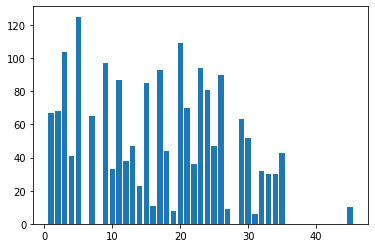

In [10]:
# distribution of num examples among subject IDs
plt.bar(pid_distrib.keys(), pid_distrib.values())

In [11]:
# write images for laughter examples
laughter_images_path = os.path.join(out_path, 'laughter_examples', 'images')
pilot_examples = random.sample(list(laughter_examples.values()), 180)
for ex in tqdm(pilot_examples):
    pass
    # ex.write_full_first_image(laughter_images_path)
(len(pilot_examples), len(laughter_examples))

  0%|          | 0/180 [00:00<?, ?it/s]

(180, 2235)

In [12]:
from coco_reader import CocoReader

In [13]:
audio_path = '/home/jose/drive/data/lared_laughter/pilot/laughter_examples/audio'
video_path = '/home/jose/drive/data/lared_laughter/pilot/laughter_examples/video'
av_path = '/home/jose/drive/data/lared_laughter/pilot/laughter_examples/av'
aiv_path = '/home/jose/drive/data/lared_laughter/pilot/laughter_examples/aiv'
img_path = './audio.png'

In [14]:
coco_reader = CocoReader('/home/jose/drive/data/lared_laughter/pilot/laughter_examples/cvat.json')

In [15]:
# write back the bbs
for hash, ex in laughter_examples.items():
    if hash not in coco_reader:
        continue
    ex.rect = coco_reader[hash]
    ex.random_pad(1.5, 3.5)
    ex.write_audio(audio_path)
    ex.write_audio_video(audio_path, img_path, aiv_path)
    ex.write_video(video_path)
    ex.write_audiovisual(video_path, audio_path, av_path)

KeyboardInterrupt: 

In [23]:
for ex in laughter_examples.values():
    ex.set_hash()

In [24]:
examples_dicts = [ex.to_dict() for ex in laughter_examples.values()]
pd.DataFrame(examples_dicts).to_csv(os.path.join(cloud_data_path, 'pilot/laughter_examples/examples.csv'))

# Speech segments

In [10]:
%load_ext autoreload
%autoreload 2
import pickle
import random
random.seed(22)
sys.path.append('../lared')
from dataset.subject import Subject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
vad_out = '/media/jose/HDD/data/lared/audio/vad'
audio_path = '/media/jose/HDD/data/lared/audio/trimmed/'

In [12]:
audiofile_map = pd.read_csv('../lared/dataset/audiofile_map.csv', index_col=0)
audiofile_map.head()

,suffix,ini,end
id,,,
1,01_2,0,6652313
2,02_2,0,6082616
3,03_2,0,6130061
4,04_2,817914,6053613
5,05_2,772051,6430197


In [13]:
subjects=list(audiofile_map.index)

In [14]:
# calculate the pid distribution
df_distrib = pd.DataFrame(pid_distrib.items(), columns=['pid', 'num'])
df_distrib = df_distrib.set_index('pid')
df_distrib['num'] = 180 * 0.3 * 2 * df_distrib['num'] / df_distrib['num'].sum()
df_distrib['num'] = df_distrib['num'].round()
df_distrib = df_distrib.astype('uint16')

In [15]:
df_distrib.loc[1, 'num']

4

In [16]:
# for each subject in the dataset
speech_examples = {}
for pid, row in audiofile_map.iterrows():
    pid = int(pid)

    subj = Subject(pid)
    subj.set_audio_path(f'/media/jose/HDD/data/lared/audio/trimmed/chan_{row["suffix"]}.wav')
    subj.set_vad_path(f'/media/jose/HDD/data/lared/audio/vad/chan_{row["suffix"]}.vad')
    # subj.load_audio()
    subj.load_vad(row['ini'], row['end'])

    examples = subj.create_speech_thin_slices(df_distrib.loc[pid, 'num'])
    for ex in examples:
        ex.set_camera()
        exs = ex.split_by_camera()
        for e in exs:
            speech_examples[e.get_hash()] = e

In [17]:
len(speech_examples)

110

In [18]:
# write images for speech examples
speech_images_path = os.path.join(out_path, 'speech_images')
pilot_examples = sample(list(speech_examples.values()), 60)
for ex in tqdm(pilot_examples):
    ex.write_full_first_image(speech_images_path)
(len(pilot_examples), len(speech_examples))

  0%|          | 0/60 [00:00<?, ?it/s]

(60, 110)

# Read CVAT annotations

In [19]:
from coco_reader import CocoReader

In [20]:
audio_path = '/home/jose/drive/data/lared_laughter/pilot/speech_examples/audio'
video_path = '/home/jose/drive/data/lared_laughter/pilot/speech_examples/video'
av_path = '/home/jose/drive/data/lared_laughter/pilot/speech_examples/av'
aiv_path = '/home/jose/drive/data/lared_laughter/pilot/speech_examples/aiv'
img_path = './audio.png'

In [21]:
coco_reader = CocoReader('/home/jose/drive/data/lared_laughter/pilot/cvat_speech.json')

In [23]:
# write back the bbs
for hash, ex in speech_examples.items():
    if hash not in coco_reader:
        continue
    ex.rect = coco_reader[hash]
    ex.random_pad(1.5, 3.5)
    ex.write_audio(audio_path)
    ex.write_audio_video(audio_path, img_path, aiv_path)
    ex.write_video(video_path)
    ex.write_audiovisual(video_path, audio_path, av_path)

In [27]:
examples_dicts = [ex.to_dict() for ex in speech_examples.values()]
pd.DataFrame(example_dicts).to_csv(os.path.join(cloud_data_path, 'pilot/speech_examples.csv'))